# Building Makemore - Exercises

Exercises from the [building makemore video](https://www.youtube.com/watch?v=PaCmpygFfXo).<br>
The video description holds the exercises, which are also listed below.

1. Watch the [building makemore video](https://www.youtube.com/watch?v=PaCmpygFfXo) on YouTube
2. Come back and complete the exercises to level up :)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Exercise 1 - Trigram Language Model

**Objective:** Train a trigram language model, i.e. take two characters as an input to predict the 3rd one.<br>
Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [2]:
# Set training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load dataset -> List[str]
words = open('../names.txt', 'r').read().splitlines()
g = torch.Generator(device=device).manual_seed(2147483647)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Special token has position zero
itos = {i:s for s,i in stoi.items()}

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    # Two char 'sliding-window'
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .


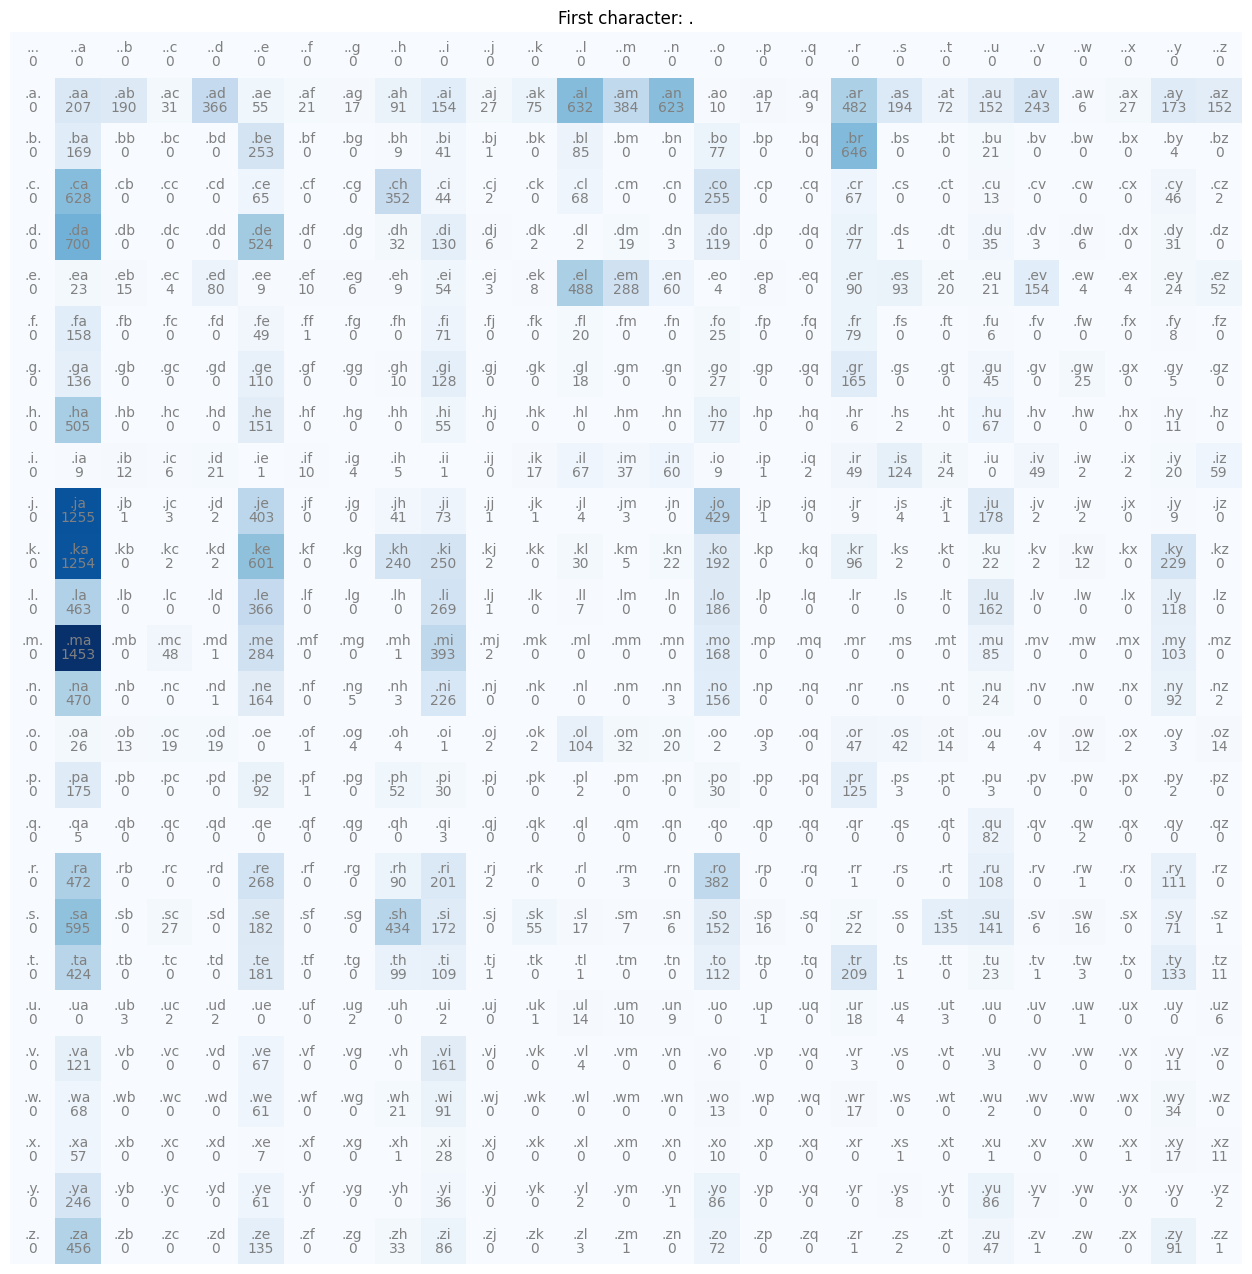

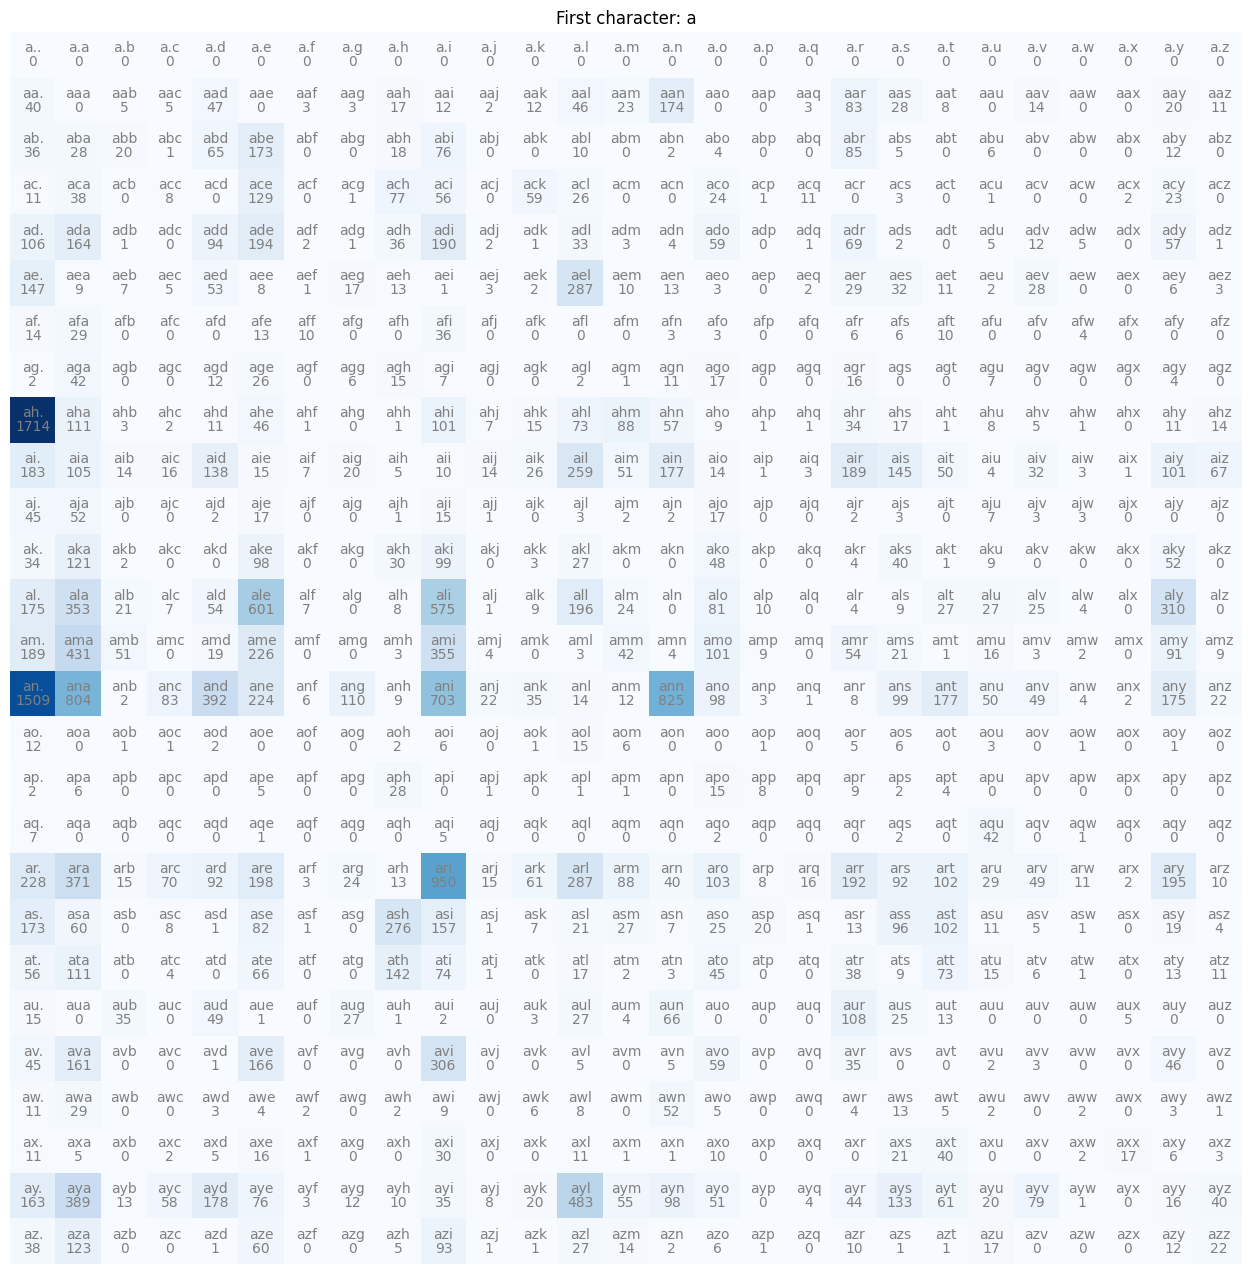

In [3]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Special token has position zero
itos = {i:s for s,i in stoi.items()}

for w in words:
    chs = ['.'] + list(w) + ['.']
    # Three token 'sliding-window'
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        N[stoi[ch1], stoi[ch2], stoi[ch3]] += 1 # Increment cell in 3D tensor by 1

# You can create 27 separate 2D heatmaps, one for each first character
# I will just create 2 for presentation purposes
for k in range(2): # 27
    plt.figure(figsize=(16, 16))
    plt.imshow(N[k], cmap='Blues')
    plt.title(f"First character: {itos[k]}")
    for i in range(27):
        for j in range(27):
            chstr = itos[k] + itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[k,i,j].item(), ha="center", va="top", color="gray")
    plt.axis('off')
    plt.show()

In [10]:
# Create training set of all bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print('number of examples', xs.shape[0])

number of examples 196113


In [13]:
xs[0]

tensor([0, 5])

In [16]:
F.one_hot(xs, num_classes=27).float().shape

torch.Size([196113, 2, 27])

In [20]:
F.one_hot(xs[0], num_classes=27)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [21]:
x0_enc = F.one_hot(xs[0], num_classes=27).float()
x0_enc.shape

torch.Size([2, 27])

In [22]:
x0_enc = x0_enc.view(1, -1)
x0_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
x_enc = F.one_hot(xs, num_classes=27).float()
x_enc.shape

torch.Size([196113, 2, 27])

In [30]:
x_enc = x_enc.view(x_enc.shape[0], -1)
x_enc.shape
x_enc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Implementing Trigram NN

In [56]:
# Create training set of all bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print('number of examples', xs.shape[0])
print('input data shape:', xs.shape)

number of examples 196113
input data shape: torch.Size([196113, 2])


In [57]:
# Initialize the network
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((54, 27), device=device, generator=g, requires_grad=True) 

In [58]:
F.one_hot(xs, num_classes=27).float().shape

torch.Size([196113, 2, 27])

In [59]:
xenc = F.one_hot(xs, num_classes=27).float().to(device) # shape: 196113, 2, 27
xenc = xenc.view(xenc.shape[0], -1) # shape: 196113, 54
logits = xenc @ W # shape: 196113, 27
counts = logits.exp() # shape: 196113, 27
counts.shape

torch.Size([196113, 27])

In [60]:
counts.sum(1, keepdims=True).shape

torch.Size([196113, 1])

In [61]:
ys.shape

torch.Size([196113])

In [62]:
probs = counts / counts.sum(1, keepdims=True)
print('len of probs:', len(probs))
probs.shape

len of probs: 196113


torch.Size([196113, 27])

In [63]:
xenc = F.one_hot(xs, num_classes=27).float().to(device) # shape: 196113, 2, 27
xenc = xenc.view(xenc.shape[0], -1) # shape: 196113, 54

In [64]:
# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):
    # Forward pass
    logits = xenc @ W # shape: 196113, 27
    counts = logits.exp() # shape: 196113, 27
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys].log().mean()  + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.1959710121154785
Loss @ iteration 2: 3.3653788566589355
Loss @ iteration 3: 3.049534320831299
Loss @ iteration 4: 2.878479480743408
Loss @ iteration 5: 2.7739577293395996
Loss @ iteration 6: 2.701239585876465
Loss @ iteration 7: 2.6454997062683105
Loss @ iteration 8: 2.601283550262451
Loss @ iteration 9: 2.5652339458465576
Loss @ iteration 10: 2.535409688949585
Loss @ iteration 11: 2.510397434234619
Loss @ iteration 12: 2.4892261028289795
Loss @ iteration 13: 2.4711146354675293
Loss @ iteration 14: 2.455474853515625
Loss @ iteration 15: 2.4418272972106934
Loss @ iteration 16: 2.4298086166381836
Loss @ iteration 17: 2.4191300868988037
Loss @ iteration 18: 2.4095733165740967
Loss @ iteration 19: 2.400963068008423
Loss @ iteration 20: 2.3931643962860107
Loss @ iteration 21: 2.386065721511841
Loss @ iteration 22: 2.3795783519744873
Loss @ iteration 23: 2.373626708984375
Loss @ iteration 24: 2.368147611618042
Loss @ iteration 25: 2.3630881309509277
Loss @ iteration 26:

## Exercise 2 - Splitting the Dataset, Evaluation on Dev and Test Sets

**Objective:** Split the dataset randomly into $80\%$ `train` set, $10\%$ `dev` set, $10\%$ `test` set.<br>
Train the bigram and trigram models only on the `training` set. Evaluate them on `dev` and `test` splits. 

What can you see?

In [49]:
len(words)

32033

In [50]:
words[0]

'emma'

In [51]:
train_set_size = int(0.8*len(words))
dev_set_size = int(0.1*len(words))
test_set_size = len(words) - train_set_size - dev_set_size

print('train set size:', train_set_size)
print('dev set size:', dev_set_size)
print('test set size:', test_set_size)

train set size: 25626
dev set size: 3203
test set size: 3204


In [5]:
g = torch.Generator(device=device).manual_seed(2147483647)

### Baselining with the bigram model

We use the bigram model code we built in the video to establish a baseline.

In [52]:
# Create set of all *bigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # Two char 'sliding-window'
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113], [196113]
num_x, num_y = xs.nelement(), ys.nelement()

In [54]:
perm = torch.randperm(num_x)
xs, ys = xs[perm], ys[perm]

tensor([3, 2, 0, 1])

In [55]:
# TODO: Shuffle/Permute the dataset, keeping pairs in sync
# TODO: Split the dataset into 80:10:10 for train:valid:test

xs_bi_train, xs_bi_valid, xs_bi_test = xs[:int(0.8*num_x)], xs[int(0.8*num_x):int(0.9*num_x)], xs[int(0.9*num_x):]
ys_bi_train, ys_bi_valid, ys_bi_test = ys[:int(0.8*num_x)], ys[int(0.8*num_x):int(0.9*num_x)], ys[int(0.9*num_x):]

In [65]:
W = torch.randn((27,27), device=device, generator=g, requires_grad=True)

# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):    
    # Forward pass
    xenc = F.one_hot(xs_bi_train, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.8105385303497314
Loss @ iteration 2: 3.421800136566162
Loss @ iteration 3: 3.1717090606689453
Loss @ iteration 4: 3.0013060569763184
Loss @ iteration 5: 2.89444637298584
Loss @ iteration 6: 2.8224775791168213
Loss @ iteration 7: 2.769425392150879
Loss @ iteration 8: 2.7287280559539795
Loss @ iteration 9: 2.696462631225586
Loss @ iteration 10: 2.6702098846435547
Loss @ iteration 11: 2.6484720706939697
Loss @ iteration 12: 2.630265951156616
Loss @ iteration 13: 2.614879846572876
Loss @ iteration 14: 2.601757287979126
Loss @ iteration 15: 2.5904502868652344
Loss @ iteration 16: 2.5805983543395996
Loss @ iteration 17: 2.5719246864318848
Loss @ iteration 18: 2.5642170906066895
Loss @ iteration 19: 2.557314395904541
Loss @ iteration 20: 2.5510921478271484
Loss @ iteration 21: 2.5454514026641846
Loss @ iteration 22: 2.540313959121704
Loss @ iteration 23: 2.5356156826019287
Loss @ iteration 24: 2.5313034057617188
Loss @ iteration 25: 2.527332067489624
Loss @ iteration 26:

In [66]:
# Validation Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_valid, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_test, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.6201272010803223
Test Loss:	 2.6236517429351807


### Comparing the bigram and trigram models

In [72]:
# TODO: Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.shape[0] # number of samples

perm = torch.randperm(num)

xs, ys = xs[perm], ys[perm]

# TODO: Shuffle/Permute the dataset, keeping (x,y) pairs in sync
# TODO: Split the dataset into 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(0.8*num)], xs[int(0.8*num):int(0.9*num)], xs[int(0.9*num):]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(0.8*num)], ys[int(0.8*num):int(0.9*num)], ys[int(0.9*num):]

In [73]:
# TODO: Implement and train a trigram model
# Training cycles, using the training dataset -> 200 Epochs
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True)

for k in range(200):
    xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) 
    xenc = xenc.view(xenc.shape[0], -1) 
    logits = xenc @ W 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_tri_train].log().mean()  + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.238903045654297
Loss @ iteration 2: 3.423207998275757
Loss @ iteration 3: 3.1153945922851562
Loss @ iteration 4: 2.9324753284454346
Loss @ iteration 5: 2.8108556270599365
Loss @ iteration 6: 2.726850748062134
Loss @ iteration 7: 2.6655170917510986
Loss @ iteration 8: 2.618793249130249
Loss @ iteration 9: 2.5817060470581055
Loss @ iteration 10: 2.551382064819336
Loss @ iteration 11: 2.5259687900543213
Loss @ iteration 12: 2.5043184757232666
Loss @ iteration 13: 2.485614776611328
Loss @ iteration 14: 2.4692916870117188
Loss @ iteration 15: 2.4549145698547363
Loss @ iteration 16: 2.4421615600585938
Loss @ iteration 17: 2.4307758808135986
Loss @ iteration 18: 2.420560598373413
Loss @ iteration 19: 2.4113545417785645
Loss @ iteration 20: 2.403026819229126
Loss @ iteration 21: 2.3954687118530273
Loss @ iteration 22: 2.3885884284973145
Loss @ iteration 23: 2.3823065757751465
Loss @ iteration 24: 2.3765549659729004
Loss @ iteration 25: 2.3712735176086426
Loss @ iteration 

In [74]:
# TODO: Evaluate the trigram model on the validation and test sets
# Validation Loss
with torch.no_grad():
    xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(xenc.shape[0], -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_tri_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
with torch.no_grad():
    xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(xenc.shape[0], -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_tri_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.272761583328247
Test Loss:	 2.2634971141815186


## Exercise 3 - Tuning the Strength of Smoothing

**Objective:** Use the *dev set* to tune the strength of smoothing (or regularization) for the trigram model - i.e.<br>
try many possibilities and see which one works best based on the dev set loss.<br>
What patterns can you see in the train and dev set loss as you tune this strength?<br>
Take the best setting of the smoothing and evaluate on the test set once and at the end.<br>
How good of a loss do you achieve?

In [97]:
# TODO: Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.shape[0] # number of samples

perm = torch.randperm(num)

xs, ys = xs[perm], ys[perm]

# TODO: Shuffle/Permute the dataset, keeping (x,y) pairs in sync
# TODO: Split the dataset into 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(0.8*num)], xs[int(0.8*num):int(0.9*num)], xs[int(0.9*num):]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(0.8*num)], ys[int(0.8*num):int(0.9*num)], ys[int(0.9*num):]

In [87]:
# from 0.0 to 1.0 in 25 steps
strengths = torch.linspace(0.0, 1.0, 25, device=device)
losst, lossv, lossf = [], [], []

for strength in tqdm(strengths, desc='Training Strengths'):
    W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

    # Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
    d_size = xs_tri_train.shape[0]
    for k in range(200):
        # Forward pass
        xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
        xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_t = -probs[torch.arange(d_size), ys_tri_train].log().mean() + strength * (W**2).mean()
        
        # Backward pass
        W.grad = None # Make sure all gradients are reset
        loss_t.backward() # Torch kept track of what this variable is, kinda cool
        
        # Weight update
        W.data += -50 * W.grad

    # Validation Loss
    d_size = xs_tri_valid.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_v = -probs[torch.arange(d_size), ys_tri_valid].log().mean() + strength * (W**2).mean()

    # Test Loss
    d_size = xs_tri_test.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_f = -probs[torch.arange(d_size), ys_tri_test].log().mean() + strength * (W**2).mean()

    # Note the losses for this strength
    losst.append((strength, loss_t))
    lossv.append((strength, loss_v))
    lossf.append((strength, loss_f))

Training Strengths:   0%|          | 0/25 [00:00<?, ?it/s]

Training Strengths: 100%|██████████| 25/25 [01:29<00:00,  3.60s/it]


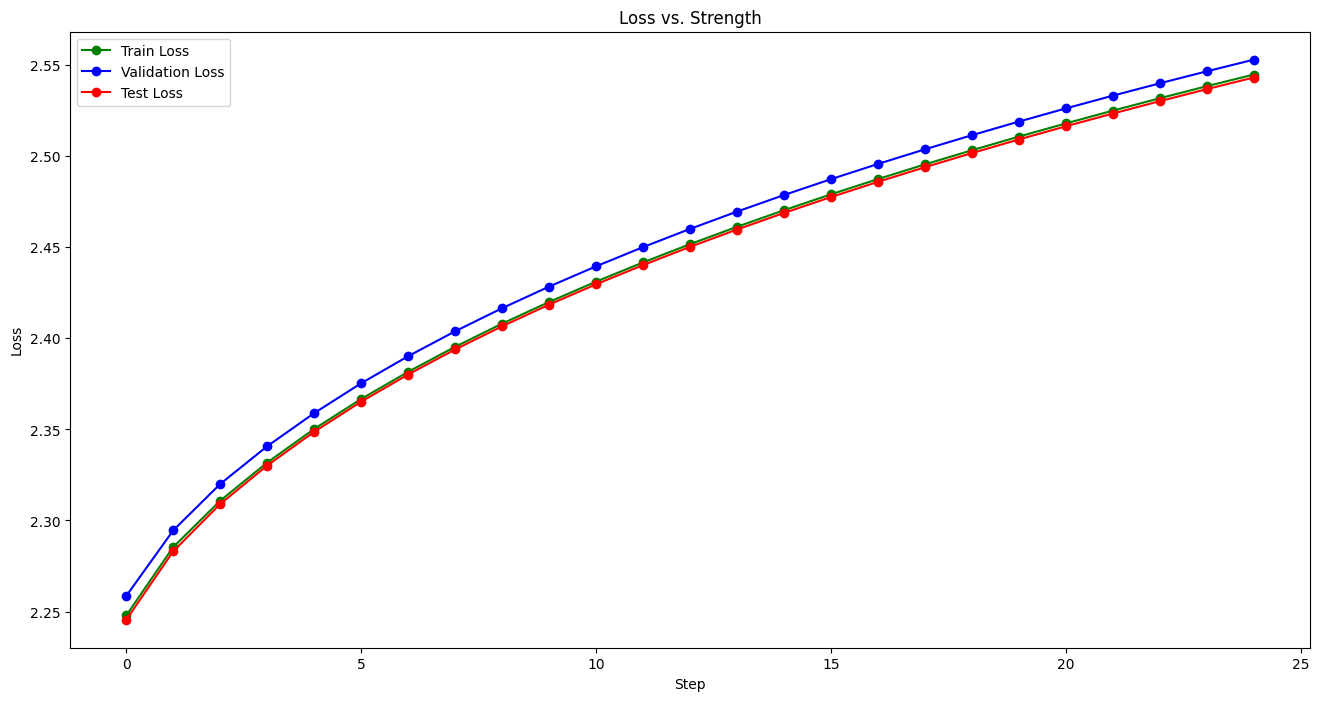

Best Strength: 0.0 @ Train: 2.24786114692688, Validation: 2.258547306060791 & Test: 2.245495080947876


In [88]:
# Plot the losses
plt.figure(figsize=(16, 8))
plt.plot([y.item() for (_, y) in losst], label='Train Loss', linestyle='-', marker='o', color='green')
plt.plot([y.item() for (_, y) in lossv], label='Validation Loss', linestyle='-', marker='o', color='blue')
plt.plot([y.item() for (_, y) in lossf], label='Test Loss', linestyle='-', marker='o', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Strength')
plt.legend()
plt.show()

# Report the best strength
print(f'Best Strength: {min(lossv, key=lambda x: x[1])[0]} @ Train: {min(losst, key=lambda x: x[1])[1]}, Validation: {min(lossv, key=lambda x: x[1])[1]} & Test: {min(lossf, key=lambda x: x[1])[1]}')

## Exercise 4 - One-Hot Vector Delete

**Objective:** We saw that our one-hot vectors merely select a row of $W$, so producing these vectors explicitly feels wasteful.<br>
Can you delete our use of `F.one_hot` in favor of simply indexing into rows of $W$?

In [89]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True)
W.shape

torch.Size([54, 27])

In [ ]:
id1, id2 = xs_tri_test[:,0], xs_tri_test[:,1]
print(id1.shape, id2.shape)

torch.Size([19612]) torch.Size([19612])


In [91]:
W[id1].shape

torch.Size([19612, 27])

In [114]:
# Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # Three char 'sliding window'
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()

# Shuffle/Permute the dataset, keeping (x,y) pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm,:], ys[perm] # xs are shuffled along the zeroth dimension

# Split 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(num_x * 0.8),:], xs[int(num_x * 0.8):int(num_x * 0.9),:], xs[int(num_x * 0.9):,:]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

In [115]:
# TODO: Rewrite the training loop to delete F.one_hot
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    id1, id2 = xs_tri_train[:,0], xs_tri_train[:,1]
    logits =  W[id1] + W[27 + id2] # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()

    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.921450138092041
Loss @ iteration 2: 3.307849884033203
Loss @ iteration 3: 3.033069372177124
Loss @ iteration 4: 2.863342523574829
Loss @ iteration 5: 2.755425214767456
Loss @ iteration 6: 2.679685354232788
Loss @ iteration 7: 2.6242682933807373
Loss @ iteration 8: 2.581174850463867
Loss @ iteration 9: 2.5465965270996094
Loss @ iteration 10: 2.5180816650390625
Loss @ iteration 11: 2.4942572116851807
Loss @ iteration 12: 2.474033832550049
Loss @ iteration 13: 2.4567041397094727
Loss @ iteration 14: 2.4416723251342773
Loss @ iteration 15: 2.428532123565674
Loss @ iteration 16: 2.4169394969940186
Loss @ iteration 17: 2.406651496887207
Loss @ iteration 18: 2.397458553314209
Loss @ iteration 19: 2.389206886291504
Loss @ iteration 20: 2.3817615509033203
Loss @ iteration 21: 2.3750176429748535
Loss @ iteration 22: 2.3688840866088867
Loss @ iteration 23: 2.3632872104644775
Loss @ iteration 24: 2.358161449432373
Loss @ iteration 25: 2.3534531593322754
Loss @ iteration 26: 2

## Exercise 5: Using F.cross_entropy

**Objective:** Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead? Here's the [documentation on `F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).

In [118]:
torch.randint(5, (3,), dtype=torch.int64)

tensor([1, 0, 0])

In [121]:
# TODO: Rewrite the training loop from Ex. 4 to employ F.cross_entropy
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    id1, id2 = xs_tri_train[:,0], xs_tri_train[:,1]
    logits =  W[id1] + W[27 + id2] # logits, different word for log-counts
    loss = F.cross_entropy(logits, ys_tri_train) + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.180330276489258
Loss @ iteration 2: 3.3986072540283203
Loss @ iteration 3: 3.079378604888916
Loss @ iteration 4: 2.8976542949676514
Loss @ iteration 5: 2.7796218395233154
Loss @ iteration 6: 2.6996328830718994
Loss @ iteration 7: 2.642163038253784
Loss @ iteration 8: 2.598076105117798
Loss @ iteration 9: 2.56282377243042
Loss @ iteration 10: 2.5338668823242188
Loss @ iteration 11: 2.5096232891082764
Loss @ iteration 12: 2.4890010356903076
Loss @ iteration 13: 2.4712488651275635
Loss @ iteration 14: 2.4558098316192627
Loss @ iteration 15: 2.442275047302246
Loss @ iteration 16: 2.4303202629089355
Loss @ iteration 17: 2.4196951389312744
Loss @ iteration 18: 2.4101924896240234
Loss @ iteration 19: 2.4016473293304443
Loss @ iteration 20: 2.3939218521118164
Loss @ iteration 21: 2.386904239654541
Loss @ iteration 22: 2.380500316619873
Loss @ iteration 23: 2.374633312225342
Loss @ iteration 24: 2.3692359924316406
Loss @ iteration 25: 2.364255666732788
Loss @ iteration 26:

## Exercise 6: Meta Exercise

**Objective:** Think of a fun/interesting exercise and complete it.

In [ ]:
# TODO: The stage is yours!